In [0]:
#import for qiskit
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit.visualization import plot_bloch_vector
from qiskit.visualization import plot_bloch_multivector
from qiskit.providers.aer.noise import NoiseModel
from qiskit.tools.monitor import job_monitor
from qiskit.providers.ibmq import least_busy
backend = Aer.get_backend('qasm_simulator') 

#some useful import
import cmath as math
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
%matplotlib inline

#import for printing
from IPython.display import display, Markdown, Latex

#turn off warnings
import warnings
warnings.filterwarnings('ignore')

#some function for plot

def alpha(counts):
    if (len(counts) == 2):
        return counts['0']/ (counts['0'] + counts['1']) 
    elif (list(counts.keys())[0] == '0'): 
        return 1
    else:
        return 0

def Z(a):
    if (a == 0):
        return math.inf
    else:
        return abs(math.sqrt(1 - 1 / a))

def q_plot(IN, fsize = (9, 2)):    
    '''visualisation of qubits'''
    fig = plt.figure(figsize = fsize)

    for i in range(len(IN)):
        ax1 = fig.add_subplot(1, len(IN), i + 1)
        a = IN[i] 
        opacity = 1 
        
        ax1.plot([0, 0, 0.3, 0.3, 0], [0, 1, 1, 0, 0], 'k', linewidth = 2)
        ax1.fill([0, 0, 0.3, 0.3, 0], [1, a, a, 1, 1] , 'w')
        
        ax1.plot([0, 0.3], [a, a], 'k')
        ax1.fill([0, 0, 0.3, 0.3, 0], [0, a, a, 0, 0] , 'k', alpha = opacity)

        ax1.set_xlim(-0.0, 0.3)
        ax1.set_ylim(-0.0, 1.)
        z = np.round(Z(a), decimals = 3)
        ax1.set_title('|z|=' +  str(z))

        ax1.axis('off')

def theo_plot():
    z = [1, math.inf, -1.0, 0.0, 1.0]
    titles = ['z='+str(1), 'z='+'$\\infty$','z='+str(-1), 'z='+str(0), 'z='+str(1)]

    fig = plt.figure(figsize = (9, 2))

    for i in range(len(z)):
        ax1 = fig.add_subplot(1, len(z), i + 1)

        if (z[i] == 1j):
            a = 1
        else:
            a = (abs(z[i] / np.sqrt(1 + abs(z[i])**2)))**2

        opacity = (np.pi + np.angle(z[i])) / (2 * np.pi)

        ax1.plot([0, 0, 0.3, 0.3, 0], [0, 1, 1, 0, 0], 'k', linewidth = 2)
        ax1.fill([0, 0, 0.3, 0.3, 0], [1, a, a, 1, 1] , 'w')

        ax1.plot([0, 0.3], [a, a], 'k')
        ax1.fill([0, 0, 0.3, 0.3, 0], [0, a, a, 0, 0] , 'k', alpha = opacity)

        ax1.set_title(titles[i])
        ax1.set_xlim(-0.0, 0.3)
        ax1.set_ylim(-0.0, 1.)
        ax1.axis('off')

In [0]:
class QCIRCUIT:
    
    def __init__(self, n, m = 1, d = 3):
        self._n = n
        self._d = d
        self._circuit = QuantumCircuit(n, m)
        self._initial_state = [0, 0, 0]
        self._parameters = [0, 0, 0]
        self._start_bit = 0
        self._end_bit = n - 1
        self._number_of_used_bits = 0

    def text(self):
        display(Latex('$$ n_{max} = \left \lceil \dfrac{m}{d - 1} \\right \\rceil-1 =' 
                      + str(int(np.ceil(self._n / (self._d - 1)) -1)) + '$$'))
    
    def cell_plot(self):
        qc = QuantumCircuit(self._d, 1)
        qc.u3(0, 0, 0, range(self._d))
        qc.cx((self._d - 1) * np.ones(self._d -1, dtype = int), range(self._d - 1))
        qc.barrier(range(self._d))
        qc.swap(0, self._d - 1)
        qc.u3(0, 0, 0, 0)
        qc.measure(0,0)
        display(qc.draw(output = 'mpl'))


    def number_of_iteration(self, n):
        '''setting the number of iteration'''
        if (n > int(np.ceil(self._n / (self._d - 1)))):
            print('ERROR #1')
        self._number_of_iteration = n
        self._requisite_bits = (n + 1) * (self._d - 1) - 1
        self._end_bit = self._requisite_bits -1
        
    def initial_state(self, x, y, z):
        '''setting the initial state of the qubit'''
        self._initial_state = [x, y, z]
    
    def parameters(self, x, y, z):
        '''setting the parameters of unitary transformation on qubits'''
        self._parameters = [x, y, z]
       
    def draw_circuit(self):
        '''drawing the circuit'''
        display(self._circuit.draw(output = 'mpl'))
        
    def _set_initial_state(self):
        #add u3 gate to bits for set the initial state of qubits
        self._circuit.u3(self._initial_state[0], self._initial_state[1], self._initial_state[2],
                        np.arange(self._requisite_bits))
        
    
    def _cell(self, bits):
        '''bits - the index of inputs qubit'''
        
        #add cnot gate to bits
        self._circuit.cx((bits[-1]) * np.ones(self._d - 1, dtype = int), bits[:-1])
        
        #just a barrier
        self._circuit.barrier(bits)
        
        #swap the bits 
        self._circuit.swap(bits[-1], self._number_of_used_bits)
        self._number_of_used_bits += 1
        
        
    def layer(self):
        while ((self._end_bit - self._number_of_used_bits) >= 2):
            for i in np.arange(self._start_bit, self._end_bit, self._d):
                if (len(np.arange(i, self._end_bit + 1)) >= self._d):
                    self._cell(np.arange(i, i + self._d))
            self._circuit.barrier(np.arange(self._n))

            self._start_bit = self._number_of_used_bits
        
        self._circuit.u3(self._parameters[0], self._parameters[1], self._parameters[2], 
                        range(self._number_of_used_bits))
            
        self._number_of_used_bits = 0
        self._end_bit = self._end_bit - (self._d - 1)
    
    def build_iteration_circuit(self):
        self._set_initial_state()
        for i in range(self._number_of_iteration):
            self.layer()
            self._circuit.barrier(range(self._n))


### Quantum circuit for iteration of function 
$$f_{d,p}(z) = \dfrac{p+z^d}{1-p^*z^d}$$

In [0]:
QC = QCIRCUIT(9) # system of 15 qubits

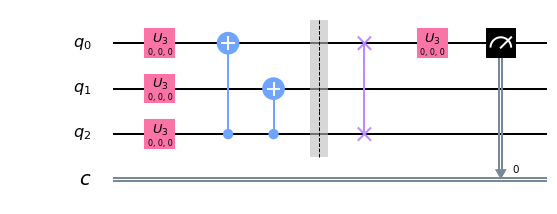

In [72]:
QC.cell_plot() # plot of circuit of on iteration

Maximum of number of iterations

$$ n_{max} = \left \lceil \dfrac{m}{d - 1} \right \rceil-1 $$
m - number of bits \\
d - degree of iterated function \\
EX: \\
$$
\begin{matrix}
m = 15 \\
d = 3 \\
\end{matrix}
\Rightarrow n_{max}= 7
$$

Matrix of $U_3$ gate
$$
\mathbf{U}_3 =  
\begin{pmatrix}
\cos\left(\frac{\theta}{2}\right)& e^{i\lambda}\sin\left(\frac{\theta}{2}\right) \\
 e^{i\varphi}\sin\left(\frac{\theta}{2}\right) & e^{i\varphi + i\lambda}\cos\left(\frac{\theta}{2}\right)\\
\end{pmatrix}
= N \cdot 
\begin{pmatrix}
1& p \\
-p^*& 1 \\
\end{pmatrix}
$$
$\Rightarrow p = - e^{i \lambda}\tan(\theta / 2) $

Matrix of CNOT gates
$$
   \mathbf{M} = 
    \begin{pmatrix}
    \mathbf{1}^{(n)} & \mathbf{0}^{(n)} \\
    \mathbf{0}^{(n)} & \mathbf{J}^{(n)} 
    \end{pmatrix}
$$

$\mathbf{1}^{(n)}$ - n dimensional identity matrix \\
$\mathbf{0}^{(n)}$ - n dimensional zero matrix \\
$\mathbf{J}^{(n)}$ - n dimensional antidiagonal all-ones matrix

$\rightarrow$ fourth iteration of $f_{3,1}(z)$ in $z = 1$ point.

Initial state is:
$$
N(z) \cdot \big(|0 \rangle + z \cdot |1 \rangle \big) = \dfrac{1}{\sqrt{2}} \cdot \big(|0 \rangle +  |1 \rangle \big) \Longleftrightarrow \mathbf{U}_3(\pi/2, 0, 0)\big(|0 \rangle +  0 \cdot |1 \rangle \big)
$$ 

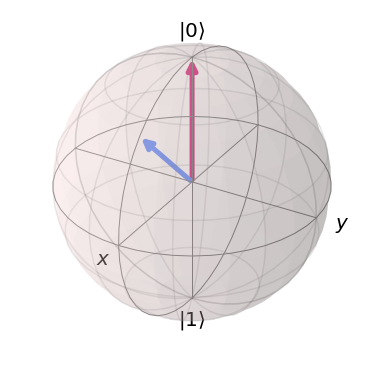

In [122]:
#rotation of state vector with U3
plot_bloch_vector([[0,0,1],[1/np.sqrt(2), 0, 1/np.sqrt(2)]])

In [0]:
#setting the initial state 
QC.initial_state(np.pi / 2, 0, 0)

$$
p = 1 \Rightarrow \lambda = 0, \varphi = 0, \theta = \frac{4k-1}{2}\pi=\frac{3}{2}\pi
$$

In [0]:
#setting the parameter of function
QC.parameters(3/2 * np.pi, 0, 0)

In [0]:
#setting number of iteration
QC.number_of_iteration(4)

In [0]:
#build the circuit
QC.build_iteration_circuit()

In [0]:
#adding a measure for the first bit
QC._circuit.measure(0,0)
circuit = QC._circuit

In [0]:
#the plot of circuit
QC.draw_circuit()

In [0]:
#simulation of circuit with Aer
EXPERIMENT = execute(circuit, backend, shots = 1000000)

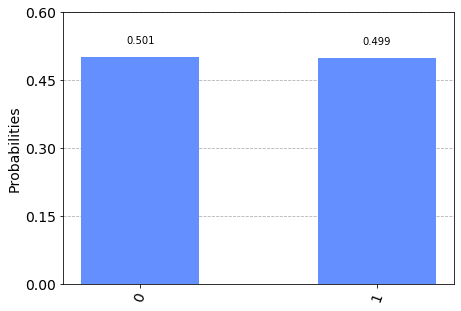

In [80]:
result = EXPERIMENT.result()
counts = result.get_counts()
plot_histogram(counts)

In [0]:
A = [0.5]
for i in range(1,5):
    
    QC = QCIRCUIT(9)
    QC.initial_state(np.pi / 2, 0, 0)
    QC.parameters(3/2 * np.pi, 0, 0)

    QC.number_of_iteration(i)
    QC.build_iteration_circuit()
    QC._circuit.measure(0,0)
    circuit = QC._circuit
    EXPERIMENT = execute(circuit, backend, shots = 1000000)
    result = EXPERIMENT.result()
    counts = result.get_counts()
    A.append(alpha(counts))

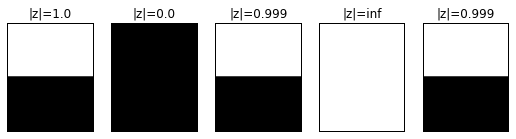

In [240]:
q_plot(A)

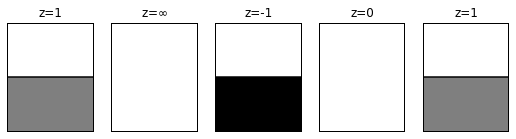

In [216]:
#z = 1 periodic orbit
theo_plot()

In [0]:
IBMQ.save_account('d8d9cf72588f5fd1c00709bd5c44a9edb6e633a20197de3a54765059dbdb3678f50cbd842e2be5009e2c52ce8c75d03233c2957ee82b308c3940a14c1b16989b')

In [224]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_essex') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [0]:
real_device = provider.get_backend('ibmq_16_melbourne')
properties = real_device.properties()
coupling_map = real_device.configuration().coupling_map

noise_model = NoiseModel.from_backend(properties)

In [0]:
QC = QCIRCUIT(9)

QC.initial_state(np.pi / 2, 0, 0)
QC.parameters(3/2 * np.pi, 0, 0)
QC.number_of_iteration(4)
QC.build_iteration_circuit()
QC._circuit.measure(0,0)

qc = QC._circuit

In [0]:
job = execute(qc, backend, shots = 1024, noise_model = noise_model,
                    coupling_map = coupling_map,
                    basis_gates = noise_model.basis_gates)

counts = job.result().get_counts()

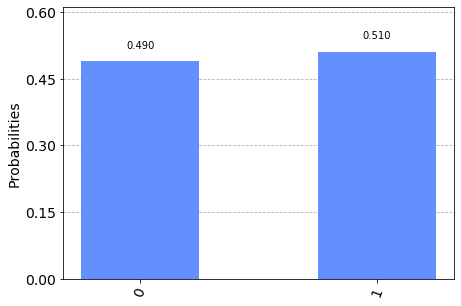

In [234]:
plot_histogram(counts)

In [0]:
A = [0.5]
for i in range(1,5):
    
    QC = QCIRCUIT(9)
    QC.initial_state(np.pi / 2, 0, 0)
    QC.parameters(3/2 * np.pi, 0, 0)

    QC.number_of_iteration(i)
    QC.build_iteration_circuit()
    QC._circuit.measure(0,0)
    
    circuit = QC._circuit
    EXPERIMENT = execute(qc, backend, shots = 1000000, noise_model = noise_model,
                    coupling_map = coupling_map,
                    basis_gates = noise_model.basis_gates)
    
    result = EXPERIMENT.result()
    counts = result.get_counts()
    A.append(alpha(counts))

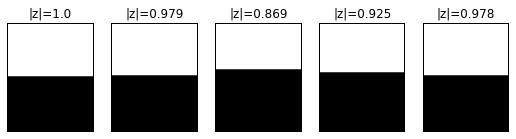

In [236]:
q_plot(A)

In [0]:
#gate on real device
# 1 iteration

QC = QCIRCUIT(3)

QC.initial_state(np.pi / 2, 0, 0)
QC.parameters(3/2 * np.pi, 0, 0)
QC.number_of_iteration(1)
QC.build_iteration_circuit()
QC._circuit.measure(0,0)

qc = QC._circuit

In [246]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()

Credentials are already in use. The existing account in the session will be replaced.


[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_essex') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [250]:
backend = provider.backends()[-3]
print(backend)

ibmq_burlington


In [251]:
shots = 1024
max_credits = 3

job_exp = execute(qc, backend, shots = shots, max_credits = max_credits)

job_monitor(job_exp)

Job Status: job has successfully run


In [0]:
result_exp1 = job_exp.result()

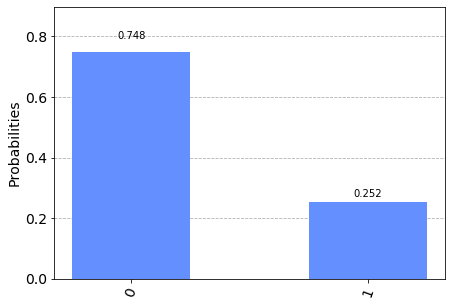

In [253]:
counts_exp1 = result_exp.get_counts(qc)
plot_histogram(counts_exp)

In [0]:
#gate on real device
# 4 iteration

QC = QCIRCUIT(9)

QC.initial_state(np.pi / 2, 0, 0)
QC.parameters(3/2 * np.pi, 0, 0)
QC.number_of_iteration(4)
QC.build_iteration_circuit()
QC._circuit.measure(0,0)

qc = QC._circuit

In [258]:
sim_backend = Aer.get_backend('qasm_simulator')
real_backend = provider.backends()[2]
print(real_backend)

ibmq_16_melbourne


In [0]:
#simulation without noise

shots = 1024
job = execute(qc, sim_backend, shots = shots)

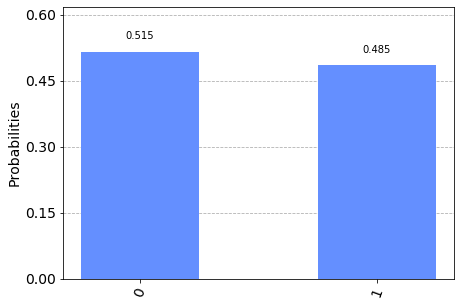

In [260]:
result = job.result()
counts = result.get_counts(qc)
plot_histogram(counts)

In [0]:
#simulation with noise

shots = 1024
job = execute(qc, sim_backend, shots = 1024, noise_model = noise_model,
                    coupling_map = coupling_map,
                    basis_gates = noise_model.basis_gates)

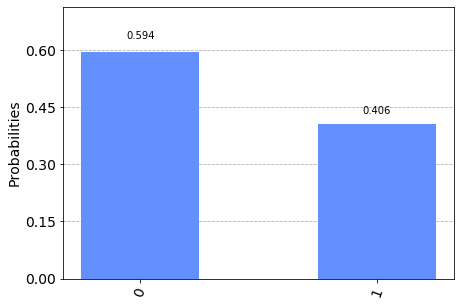

In [265]:
result = job.result()
counts = result.get_counts(qc)
plot_histogram(counts)

In [266]:
shots = 1024
max_credits = 3

job_exp = execute(qc, real_backend, shots = shots, max_credits = max_credits)

job_monitor(job_exp)

Job Status: job has successfully run


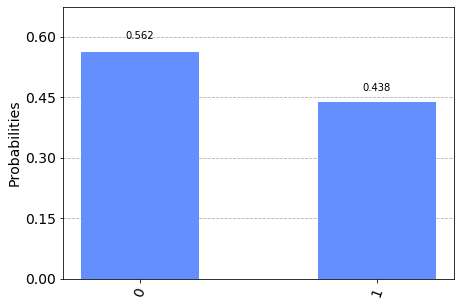

In [268]:
result = job_exp.result()
counts = result.get_counts(qc)
plot_histogram(counts)